In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import joblib

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [2]:
# === Set hyperparameters ===
epochs = 1000
batch_size = 32
learning_rate = 1e-4
dropout_prob = 0.3
latent_dim = 10
hidden_dim = 512
use_batchnorm = False
kl_anneal_epochs = epochs // 10 if epochs <= 1000 else 100
beta_max = 1.0
patience = 20
grad_clip_value = 1.0
# === Set random seed for reproducibility ===
torch.manual_seed(2025)
np.random.seed(2025)

In [3]:
# === Load and normalize your data ===
gene_df = pd.read_table("ko_table.tsv", index_col=0)
# For demonstration:
# gene_df = pd.DataFrame(np.random.rand(100, 5000))

In [4]:
scaler = StandardScaler()
gene_df_scaled = scaler.fit_transform(gene_df)
data_tensor = torch.tensor(gene_df_scaled, dtype=torch.float32).to(device)
dataset = TensorDataset(data_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [5]:
# === VAE with Dropout and Normalization ===
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, latent_dim=10, dropout_prob=0.2, use_batchnorm=True):
        super(VAE, self).__init__()
        self.use_batchnorm = use_batchnorm

        # Encoder
        self.encoder_fc = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout_prob)
        self.relu = nn.ReLU()

        self.mu_layer = nn.Linear(hidden_dim, latent_dim)
        self.logvar_layer = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.decoder_fc1 = nn.Linear(latent_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim)
        self.decoder_fc2 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        x = self.encoder_fc(x)
        x = self.bn1(x) if self.use_batchnorm else self.ln1(x)
        x = self.relu(x)
        x = self.dropout(x)
        return self.mu_layer(x), self.logvar_layer(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = self.decoder_fc1(z)
        z = self.bn2(z) if self.use_batchnorm else self.ln2(z)
        z = self.relu(z)
        z = self.dropout(z)
        return self.decoder_fc2(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

# === Loss Function with KL Annealing ===
def loss_function(recon_x, x, mu, logvar, kl_weight):
    recon_loss = nn.MSELoss()(recon_x, x)
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_weight * kl_loss, recon_loss.item(), kl_loss.item()

# === Train the model ===
def train_vae(model, dataloader, optimizer, device, epochs=100, beta_max=1.0, kl_anneal_epochs=50, grad_clip_value=1.0, patience=20):
    model.train()
    loss_history = []
    recon_history = []
    kl_history = []
    best_loss = float("inf")
    counter = 0

    for epoch in range(epochs):
        total_loss = 0
        total_recon = 0
        total_kl = 0

        # Linearly anneal beta from 0 to beta_max
        beta = beta_max * min(1.0, epoch / kl_anneal_epochs)

        for batch in dataloader:
            batch = batch[0].to(device)
            optimizer.zero_grad()
            x_recon, mu, logvar = model(batch)

            recon_loss = F.mse_loss(x_recon, batch, reduction="sum") / batch.size(0)
            kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / batch.size(0)

            # Optional: Add small latent regularization to prevent collapse
            latent_l1 = torch.mean(torch.abs(mu))
            latent_penalty = 1e-3 * latent_l1

            loss = recon_loss + beta * kl_div + latent_penalty
            loss.backward()

            # Gradient clipping
            if grad_clip_value is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_value)

            optimizer.step()

            total_loss += loss.item()
            total_recon += recon_loss.item()
            total_kl += kl_div.item()

        avg_loss = total_loss / len(dataloader)
        avg_recon = total_recon / len(dataloader)
        avg_kl = total_kl / len(dataloader)

        loss_history.append(avg_loss)
        recon_history.append(avg_recon)
        kl_history.append(avg_kl)

        print(
            f"Epoch [{epoch+1}/{epochs}] Loss: {avg_loss:.4f} | Recon: {avg_recon:.4f} | KL: {avg_kl:.4f} | Beta: {beta:.4f}"
        )

        # Early stopping
        if avg_loss < best_loss:
            best_loss = avg_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered.")
                break

    history = {
        "epoch": list(range(1, len(loss_history) + 1)),
        "loss": loss_history,
        "reconstruction_loss": recon_history,
        "kl_divergence": kl_history,
    }

    return model, history

In [6]:
# === Model Setup ===
input_dim = gene_df.shape[1]
vae = VAE(input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim, dropout_prob=dropout_prob, use_batchnorm=use_batchnorm).to(device)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

# === Train the model ===
vae, history = train_vae(vae, dataloader, optimizer, device, epochs=epochs, kl_anneal_epochs=kl_anneal_epochs, grad_clip_value=grad_clip_value, patience=patience)

# === Save the model and scaler ===
torch.save(vae.state_dict(), "vae_model.pth")
joblib.dump(scaler, "scaler.pkl")

Epoch [1/1000] Loss: 7797.2993 | Recon: 7797.2976 | KL: 23.9053 | Beta: 0.0000
Epoch [2/1000] Loss: 6600.2516 | Recon: 6599.8646 | KL: 38.5039 | Beta: 0.0100
Epoch [3/1000] Loss: 6211.0463 | Recon: 6210.1227 | KL: 46.0728 | Beta: 0.0200
Epoch [4/1000] Loss: 5955.8933 | Recon: 5954.2970 | KL: 53.1343 | Beta: 0.0300
Epoch [5/1000] Loss: 5767.3418 | Recon: 5764.9808 | KL: 58.9670 | Beta: 0.0400
Epoch [6/1000] Loss: 5615.4471 | Recon: 5612.2419 | KL: 64.0537 | Beta: 0.0500
Epoch [7/1000] Loss: 5500.5499 | Recon: 5496.4560 | KL: 68.1889 | Beta: 0.0600
Epoch [8/1000] Loss: 5370.6464 | Recon: 5365.5798 | KL: 72.3435 | Beta: 0.0700
Epoch [9/1000] Loss: 5298.1049 | Recon: 5292.0616 | KL: 75.5078 | Beta: 0.0800
Epoch [10/1000] Loss: 5213.4513 | Recon: 5206.3093 | KL: 79.3265 | Beta: 0.0900
Epoch [11/1000] Loss: 5131.3149 | Recon: 5123.1557 | KL: 81.5637 | Beta: 0.1000
Epoch [12/1000] Loss: 5059.5205 | Recon: 5050.2097 | KL: 84.6184 | Beta: 0.1100
Epoch [13/1000] Loss: 5030.7251 | Recon: 5020.465

['scaler.pkl']

# VAE Evaluation

In [12]:
# === Extract Latent Representations & Reconstructions ===
vae.eval()
with torch.no_grad():
    # full data
    recon_all, mu_all, logvar_all = vae(data_tensor)
    latent_repr = mu_all.numpy()          # shape: (n_samples, latent_dim)
    reconstructed = recon_all.numpy()     # scaled-space reconstruction
    # inverse transform back to original scale
    reconstructed_orig = scaler.inverse_transform(reconstructed)
    reconstructed_df = pd.DataFrame(reconstructed_orig, columns=gene_df.columns, index=gene_df.index)

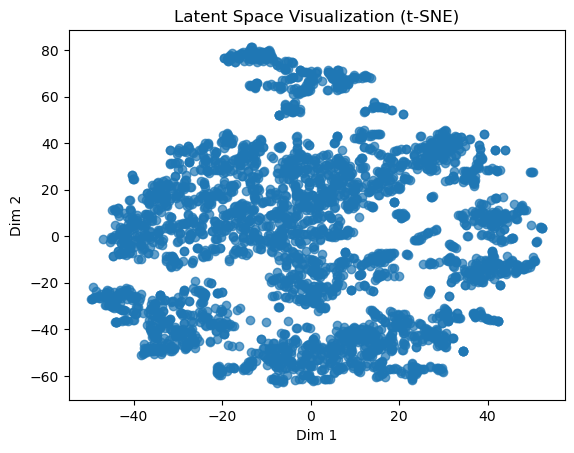

In [13]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# If latent_repr is (n_samples, latent_dim)
tsne = TSNE(n_components=2)
z_tsne = tsne.fit_transform(latent_repr)

plt.scatter(z_tsne[:, 0], z_tsne[:, 1], alpha=0.7)
plt.title("Latent Space Visualization (t-SNE)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.show()


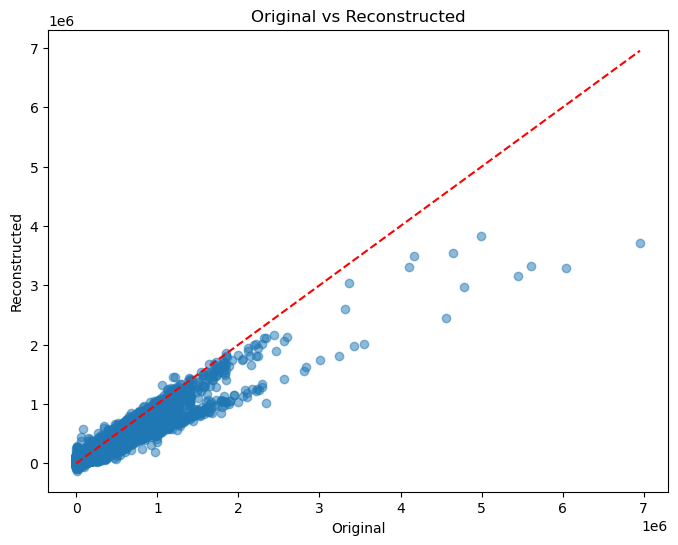

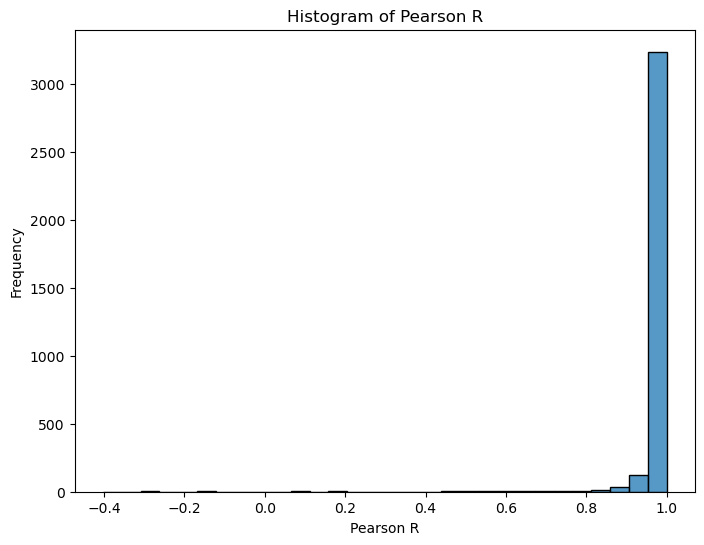

In [30]:
# Assessing reconstruction quality via pearson r
from scipy.stats import pearsonr
import seaborn as sns
def pearson_r(x, y):
    return pearsonr(x, y)[0]
# Compute Pearson correlation for each gene
pearson_results = []
for i in range(reconstructed_orig.shape[0]):
    r = pearson_r(gene_df.iloc[i, :], reconstructed_orig[i, :])
    pearson_results.append(r)
# Create a DataFrame for results
pearson_df = pd.DataFrame({
    'sample_id': gene_df.index,
    'Pearson_R': pearson_results
})
pearson_df = pearson_df.sort_values(by='Pearson_R', ascending=False)
# Plot scatter plot of original vs reconstructed
plt.figure(figsize=(8, 6))
plt.scatter(gene_df.values.flatten(), reconstructed_orig.flatten(), alpha=0.5)
plt.title("Original vs Reconstructed")
plt.xlabel("Original")
plt.ylabel("Reconstructed")
plt.plot([gene_df.values.min(), gene_df.values.max()], [gene_df.values.min(), gene_df.values.max()], 'r--')
plt.show()
# Plot histogram of Pearson R
plt.figure(figsize=(8, 6))
sns.histplot(pearson_df['Pearson_R'], bins=30)
plt.title("Histogram of Pearson R")
plt.xlabel("Pearson R")
plt.ylabel("Frequency")
plt.show()

In [15]:
# === Generate data ===
def generate_data(model, num_samples=50):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        generated_data = model.decode(z).cpu().numpy()
        generated_data = scaler.inverse_transform(generated_data)
        generated_data = pd.DataFrame(generated_data, columns=gene_df.columns)
    return generated_data
# Generate new data
generated_data = generate_data(vae)
generated_data

,K00001,K00002,K00003,K00004,K00005,K00007,K00008,K00009,K00010,K00011,...,K22503,K22504,K22505,K22506,K22507,K22508,K22509,K22510,K22511,K22512
0,141055.546875,24499.718750,278333.468750,15367.150391,42759.824219,-583.801880,63985.542969,153984.515625,15119.423828,54.710396,...,2.410823,3.201335,-19.155628,-4.734705,-19.270609,-19.011456,-18.579926,-30.002262,-20.528532,-19.246796
1,35395.390625,389.560822,8999.667969,528.124878,11352.926758,5781.210938,-21.763676,18086.583984,17552.816406,6.075562,...,0.140663,-3.295483,-5.762814,3.628325,-5.840161,-5.270198,-6.629199,1.918360,-4.886285,-4.807565
2,51628.527344,2885.648438,94663.695312,3987.365723,22213.128906,544.864746,34914.628906,78933.492188,7337.763672,164.383896,...,2.638229,90.648552,-8.853654,-14.967501,-9.168077,-8.775880,-9.384527,-8.667522,-8.011019,-8.364365
3,88211.828125,11190.961914,163007.640625,12655.104492,49038.425781,132.745895,90729.812500,43549.800781,4147.092285,53.073727,...,-1.505419,59.043289,35.115299,32.202564,36.305798,34.905972,36.173199,38.657249,36.038124,35.819557
4,64770.507812,9637.592773,135806.687500,4697.900391,39419.496094,996.087891,58682.187500,36071.507812,9432.422852,-13.994376,...,5.417304,51.947052,61.085590,78.593552,60.780811,61.781044,61.559120,68.597969,60.753551,61.615868
5,116452.554688,14931.224609,266488.500000,10234.777344,68376.437500,88.067230,100458.234375,136263.343750,8219.979492,38.986626,...,-0.754850,27.037674,7.776168,44.658241,9.160394,8.844740,7.659811,6.614154,7.879980,6.229497
6,177466.234375,-9209.138672,71340.281250,45102.253906,10572.903320,6235.682129,-621.005859,49308.796875,9173.273438,-51.225529,...,0.369751,0.873880,23.915609,22.669399,24.815481,22.465548,24.369576,17.389929,23.588755,22.523966
7,15435.564453,895.348694,22866.478516,2468.305664,5372.186035,1668.655151,21315.703125,79358.945312,4859.152832,62.908302,...,4.542909,20.283781,-18.134501,-26.724516,-19.550098,-19.434486,-18.513744,-28.494833,-18.419468,-18.494473
8,107050.296875,21544.953125,275874.718750,9414.966797,93068.171875,-2118.387695,198393.328125,64302.222656,13632.272461,-16.825165,...,1.441350,-48.771076,-26.075918,-10.717567,-27.334129,-27.056767,-27.075672,-21.629303,-26.741131,-28.692692
9,137249.562500,30947.486328,358014.187500,16854.957031,113567.523438,-1795.638428,174068.468750,106318.328125,22674.021484,-51.022415,...,-0.360818,-56.544296,-29.346310,-26.167021,-29.169088,-29.205654,-28.512197,-42.869770,-29.643675,-29.331455


In [21]:
species_df = pd.read_table("otus_table.tsv", index_col=0).T
species_tensor = torch.tensor(species_df.values, dtype=torch.float32).to(device)

In [22]:
# === Train a regression model on the latent space ===
# === Define a simple MLP for regression ===
class MLPRegressor(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        super(MLPRegressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)

# === Train a regression model on the latent space ===
from sklearn.model_selection import train_test_split

# Split latent representations + targets
X_train, X_test, y_train, y_test = train_test_split(
    torch.tensor(latent_repr, dtype=torch.float32).to(device),
    species_tensor,
    test_size=0.2
)

regressor = MLPRegressor(input_dim=latent_repr.shape[1], output_dim=species_tensor.shape[1]).to(device)
reg_optimizer = optim.Adam(regressor.parameters(), lr=1e-3)
reg_criterion = nn.MSELoss()

# Wrap data into DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Training loop
regressor.train()
for epoch in range(50):
    running_loss = 0
    for x_batch, y_batch in train_loader:
        reg_optimizer.zero_grad()
        preds = regressor(x_batch)
        loss = reg_criterion(preds, y_batch)
        loss.backward()
        reg_optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1:03d} | Regression Loss: {running_loss:.4f}")

# === Evaluate the regression model === #
regressor.eval()
with torch.no_grad():
    preds = regressor(X_test)
    test_loss = reg_criterion(preds, y_test).item()
    print(f"\nTest MSE: {test_loss:.4f}")

    # Optional: compute R^2 per species
    from sklearn.metrics import r2_score
    r2 = r2_score(y_test.cpu().numpy(), preds.cpu().numpy(), multioutput='raw_values')
    print(f"R² per species:\n{r2}")
    print(f"Mean R²: {r2.mean():.4f}")


Epoch 001 | Regression Loss: 5209587.6270
Epoch 002 | Regression Loss: 5307213.8203
Epoch 003 | Regression Loss: 5291001.3203
Epoch 004 | Regression Loss: 5229626.6289
Epoch 005 | Regression Loss: 5293805.4375
Epoch 006 | Regression Loss: 5257227.0781
Epoch 007 | Regression Loss: 5261225.1172
Epoch 008 | Regression Loss: 5249639.5547
Epoch 009 | Regression Loss: 5184580.0234
Epoch 010 | Regression Loss: 5183462.8555
Epoch 011 | Regression Loss: 5169056.5508
Epoch 012 | Regression Loss: 5167971.4141
Epoch 013 | Regression Loss: 5188664.0938
Epoch 014 | Regression Loss: 5243149.1797
Epoch 015 | Regression Loss: 5124896.7266
Epoch 016 | Regression Loss: 5190164.5078
Epoch 017 | Regression Loss: 5122700.8594
Epoch 018 | Regression Loss: 5115818.5508
Epoch 019 | Regression Loss: 5161218.1406
Epoch 020 | Regression Loss: 5051102.3906
Epoch 021 | Regression Loss: 5095904.7188
Epoch 022 | Regression Loss: 5116005.7812
Epoch 023 | Regression Loss: 5060576.6836
Epoch 024 | Regression Loss: 50127